In [1]:
import inspect
import numpy as np
import pandas as pd
import csv
import sklearn
import time
import seaborn as sb
import matplotlib.pyplot as plt

# Listing version of all modules:
for n in dir():
    if inspect.ismodule(eval(n)):
        if '__version__' in dir(eval(n)):
            print(f"{eval(f'{n}.__name__')}: {eval(f'{n}.__version__')}")
        elif '_version_' in dir(eval(n)):
            print(f"{eval(f'{n}.__name__')}: {eval(f'{n}._version_')}")

csv: 1.0
numpy: 1.23.4
pandas: 1.4.4
seaborn: 0.11.2
sklearn: 1.1.3


In [2]:
# Auxiliary Functions

def make_fitness_plot(model, x_train, y_train, x_test, y_test, y_name='Property', ax=None):
  y_train_pred = model.predict(x_train)
  y_test_pred = model.predict(x_test)
  if not ax:
    fig, ax = plt.subplots()
  l_train = ax.scatter(y_train,y_train_pred)
  l_test = ax.scatter(y_test,y_test_pred)
  y_full=np.concatenate((y_test,y_train))
  l3 = ax.plot(y_full,y_full)
  ax.set_xlabel(f"{y_name} (Original)")
  ax.set_ylabel(f"{y_name} (Predicted)")
  l = ax.legend([l_train,l_test],['Train data','Test data'])

def make_residual_plot(model, x_train, y_train, x_test, y_test, y_name='Property', ax=None):
  y_train_pred = model.predict(x_train)
  y_test_pred = model.predict(x_test)
  if not ax:
    fig, ax = plt.subplots()
  l_train = ax.scatter(y_train,y_train_pred-y_train)
  l_test = ax.scatter(y_test,y_test_pred-y_test)
  y_full=np.concatenate((y_test,y_train))
  l3 = ax.hlines(0, 0, 1, transform=ax.get_yaxis_transform(), colors='black')
  ax.set_xlabel(f"{y_name} (Original)")
  ax.set_ylabel(f"Residuals")
  l = ax.legend([l_train,l_test],['Train data','Test data'])

## Data Pre-treatment

The original data contains values for the cell viability in each assay, plus one column with the average viability for a given composition. The following code removes the average values and expands the data from the individual cell viability assays. 

In [10]:
o=dict()
c_names=['Amostra','Replica','Csys','Ag_s','FU_s','Ag_l','FU_l','Cell_viab','Label']

for cname in c_names:
  o[cname]=list()

with open('221028-dados_raquel_corrigidos.csv','r') as f:
  reader = csv.reader(f)
  for l in reader:
    am, csys, ag_s, fu_s, fu_l, ag_l = l[:6]
    if am == 'Amostra': continue
    label = l[-1]
    for i,cv in enumerate(l[6:-2]): # cols com os ensaios individuais
      if 'NA' not in cv:
        o['Amostra'].append(am)
        o['Replica'].append(f"{am}_{i+1}")
        o['Csys'].append(float(csys))
        o['Ag_s'].append(float(ag_s))
        o['FU_s'].append(float(fu_s))
        o['Ag_l'].append(float(ag_l))
        o['FU_l'].append(float(fu_l))
        o['Cell_viab'].append(float(cv))
        o['Label'].append(label)

data = pd.DataFrame(o)
#data = data.drop(data[data['Ag_s']>0.0].index)
#data = data.drop(data[data['FU_s']>0.0].index)
#data = data.drop(labels=['Ag_s','FU_s'],axis=1)
data.to_csv('221028-loaded_solution_data.csv',index=False)
data['AgY']=0.0 #mg/mL
data['Ag(5-FU)@Y']=0.0 #mg/mL
data['5-FU@Y']=0.0 #mg/mL
#data['Ag4Y']=0.0
#data['Ag7Y']=0.0
#data['Ag4(5-FU)@Y']=0.0
#data['Ag7(5-FU)@Y']=0.0

#print(data.to_dict())

ddata=data.to_dict()

for idx,val in ddata['Label'].items():
    if 'livre' in val.lower():
        continue
    elif val.strip() in ('Ag4Y','Ag4Y ctl'):
        ddata['AgY'][idx]=ddata['Csys'][idx]
    elif val.strip() in ('Ag7Y','Ag7Y ctl'):
        ddata['AgY'][idx]=ddata['Csys'][idx]
    elif val.strip() in ('5-FU@Y'):
        ddata['5-FU@Y'][idx]=ddata['Csys'][idx]
    elif val.startswith('(1:1) Ag(5-FU)@Y:5-FU@Y'):
        ddata['5-FU@Y'][idx]=0.5*ddata['Csys'][idx]
        ddata['Ag(5-FU)@Y'][idx]=0.5*ddata['Csys'][idx]
    elif val.startswith('(1:5) Ag(5-FU)@Y:5-FU@Y'):
        ddata['5-FU@Y'][idx]=(5/6)*ddata['Csys'][idx]
        ddata['Ag(5-FU)@Y'][idx]=(1/6)*ddata['Csys'][idx]
    elif val.startswith('(5:1) Ag(5-FU)@Y:5-FU@Y'):
        ddata['5-FU@Y'][idx]=(1/6)*ddata['Csys'][idx]
        ddata['Ag(5-FU)@Y'][idx]=(5/6)*ddata['Csys'][idx]
    elif val.startswith('(1:1) AgY:5-FU@Y') or val.startswith('(1:5) AgY:5-FU@Y') or val.startswith('(5:1) AgY:5-FU@Y'):
        ddata['5-FU@Y'][idx]=0.5*ddata['Csys'][idx]
        ddata['AgY'][idx]=0.5*ddata['Csys'][idx]
    elif val.strip().startswith('Ag4(5-FU)@Y'):
        ddata['Ag(5-FU)@Y'][idx]=ddata['Csys'][idx]
    elif val.strip().startswith('Ag7(5-FU)@Y'):
        ddata['Ag(5-FU)@Y'][idx]=ddata['Csys'][idx]
    else:
        continue


data=pd.DataFrame(ddata)      

### REMOVE UNWANTED DATA POINTS ###
# Remove S86, S87, S88, S98, S99, S100 
data.drop([y[0] for y in np.argwhere([x in ['S86','S87','S88','S98','S99','S100'] for x in data['Amostra']])],inplace=True) 

# convert aq. concentrations to mg/mL
data['Ag_l']=data['Ag_l']*0.10786 # mg/mL
data['FU_l']=data['FU_l']*0.13008 # mg/mL
#ynp.argwhere([x in ['S86','S87','S88','S98','S99','S100'] for x in data['Amostra']])

data.to_excel('221123-raquel_data_expanded.xlsx',index=False)
data

# data for only solids and only aq preparations
data['Cell_Death'] = [max(0,100.0 - x) for x in data['Cell_viab']]
s_data=data.loc[((data['AgY']>0) | (data['Ag(5-FU)@Y']>0) | (data['5-FU@Y'] > 0))]
l_data=data.loc[((data['Ag_l']>0) | (data['FU_l']>0))]

## Preliminary Data Analysis

## Tunning ANN for Solid-state drug delivery systems

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Inc

Score (train) = 0.9425
Score (test)  = 0.8971
Time to train = 1503.0 s


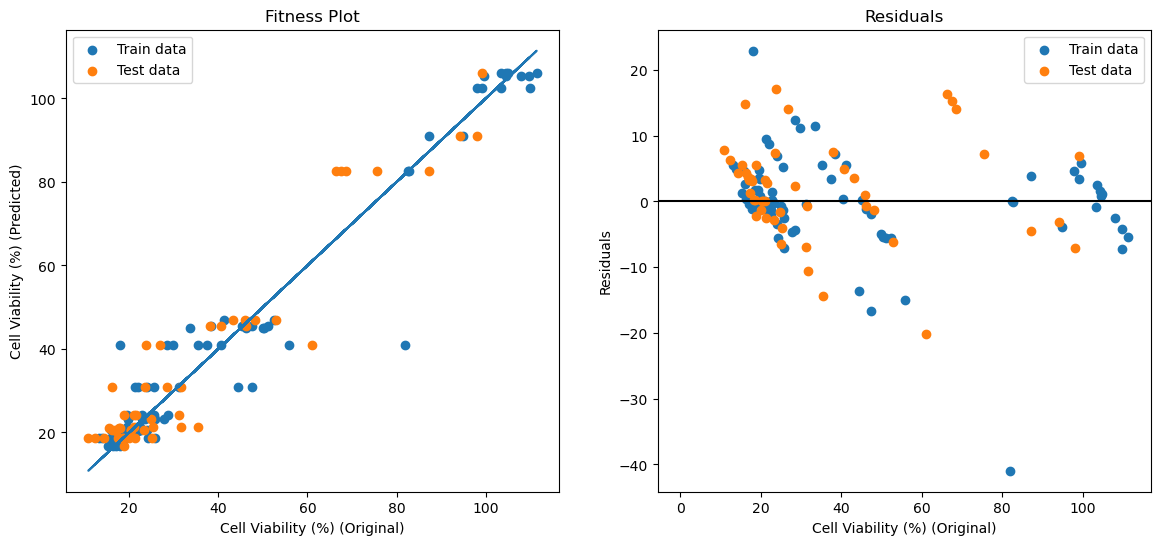

Best parameters:
prepare__numerical__featurize__degree: 2
regressor__alpha    : 0.001
regressor__hidden_layer_sizes: (50,)


/usr/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


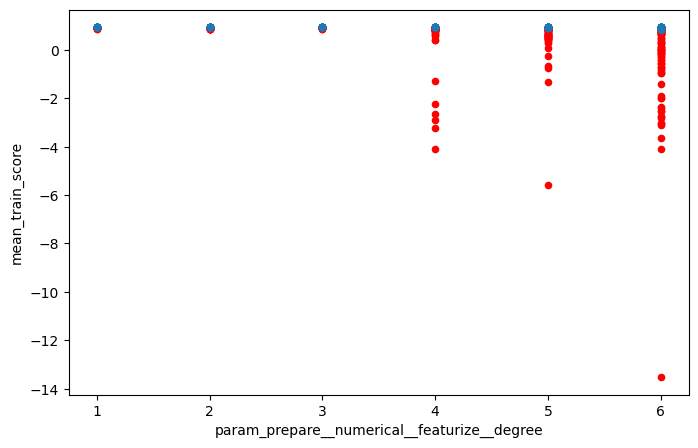

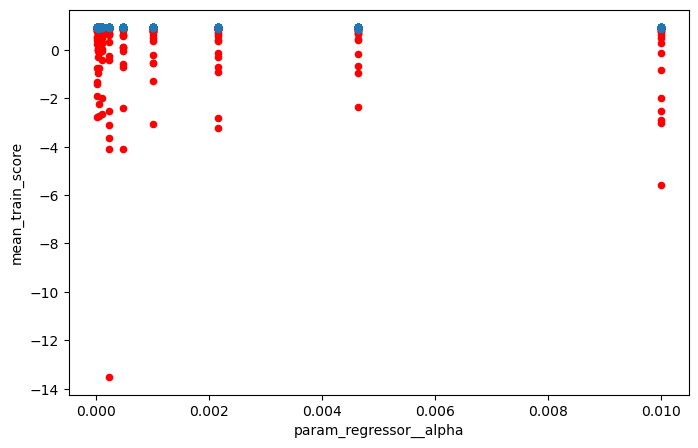

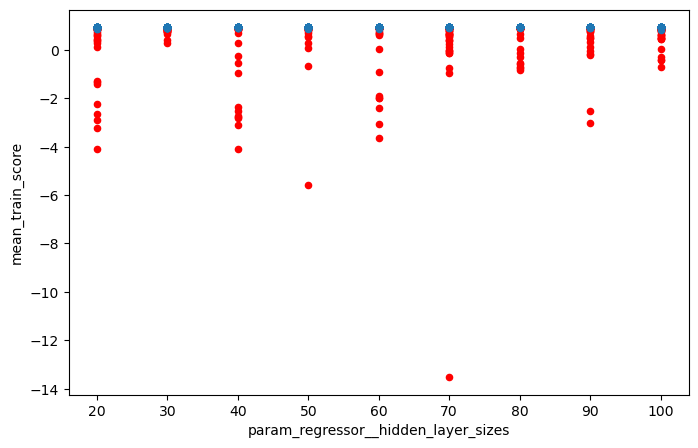

In [17]:
# ANN Regression

from sklearn import model_selection
from sklearn import pipeline
from sklearn import neural_network
from sklearn import compose
from sklearn import preprocessing

target = 'Cell_viab'
features = ['AgY' ,'Ag(5-FU)@Y','5-FU@Y']
basename = '221122-modelo_linear'

train_set, test_set = model_selection.train_test_split(s_data,train_size=0.6,random_state=42)

X_train = train_set[features]
Y_train = train_set[target]
X_test = test_set[features]
Y_test = test_set[target]

num_pross = pipeline.Pipeline(steps=[('scale',preprocessing.StandardScaler()),
                                     ('featurize',preprocessing.PolynomialFeatures())])

pre_transformer = compose.ColumnTransformer([
                  ('numerical',num_pross,compose.make_column_selector(dtype_include=np.number),
                  )
                   ], remainder='passthrough')

reg = neural_network.MLPRegressor(solver='lbfgs', max_iter=10_000, random_state=42)

model_pipe = pipeline.Pipeline(steps=[('prepare',pre_transformer),
                                      ('regressor',reg)])

hyper_params=dict()
#hyper_params["regressor__C"]= np.linspace(0.5,1.5, 10)
hyper_params["prepare__numerical__featurize__degree"]=[1,2,3,4,5,6]
#hyper_params["regressor__alpha"]= np.linspace(0.00001,0.01, 40)
hyper_params["regressor__alpha"]= np.logspace(-5,-2, 10)
hyper_params["regressor__hidden_layer_sizes"]=[(x,) for x in [20,30,40,50,60,70,80,90,100]]


s_model = model_selection.GridSearchCV(model_pipe,hyper_params,refit=True, return_train_score=True, n_jobs=4, verbose=1)
#model = model_pipe

start=time.time()
s_model.fit(X_train,Y_train)
end=time.time()

print(f"Score (train) = {s_model.score(X_train,Y_train):6.4f}")
print(f"Score (test)  = {s_model.score(X_test,Y_test):6.4f}")
print(f"Time to train = {end-start:0.1f} s")

fig, axs = plt.subplots(1,2,figsize=(14,6))
axs[0].set_title("Fitness Plot")
make_fitness_plot(s_model,X_train,Y_train,X_test,Y_test,'Cell Viability (%)',ax=axs[0])
axs[1].set_title("Residuals")
make_residual_plot(s_model,X_train,Y_train,X_test,Y_test,'Cell Viability (%)',ax=axs[1])
plt.show()

if True:
    # Best estimator hyper-parameters
    print("Best parameters:")
    for pname,val in s_model.best_params_.items():
      print(f"{pname:20s}: {val}")
    cv_data=pd.DataFrame(s_model.cv_results_)
    cv_data["param_regressor__hidden_layer_sizes"] = [x[0] for x in cv_data["param_regressor__hidden_layer_sizes"]]
    for k in hyper_params:
        _, ax= plt.subplots(figsize=(8,5))
        l1=cv_data.plot.scatter(x=f"param_{k}",y="mean_test_score",ax=ax,color='red')
        l2=cv_data.plot.scatter(x=f"param_{k}",y="mean_train_score",ax=ax)
        plt.show()

In [18]:
cv_data.to_excel("221123-ANN_opt-cv_data.xlsx", index=False)

### Fine-tunning in the 40-60 neuron range

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Inc

Score (train) = 0.9425
Score (test)  = 0.8971
Time to train = 1583.7 s


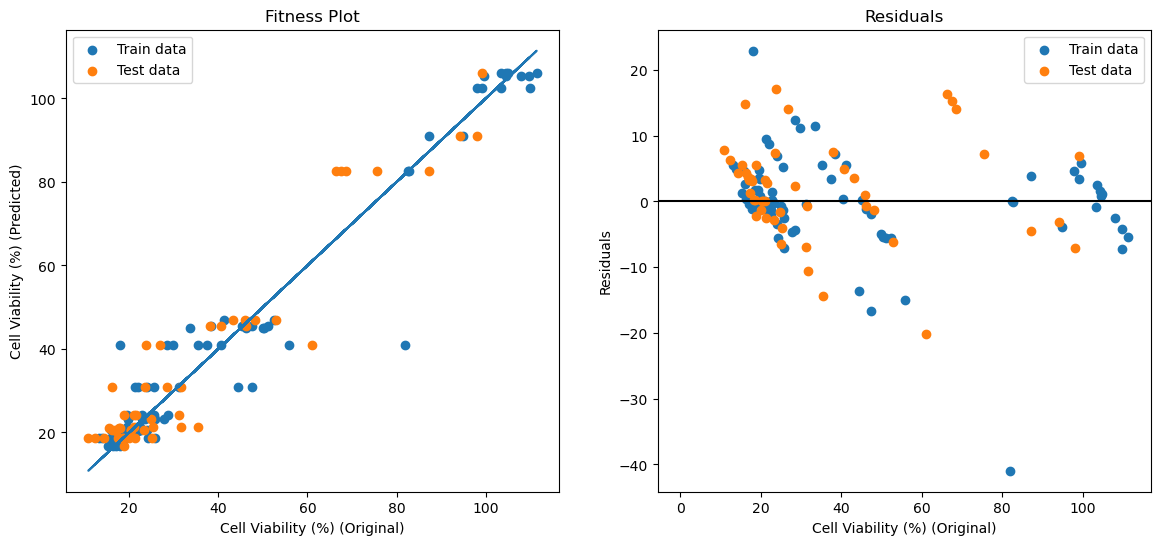

Best parameters:
prepare__numerical__featurize__degree: 2
regressor__alpha    : 0.001
regressor__hidden_layer_sizes: (50,)


/usr/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


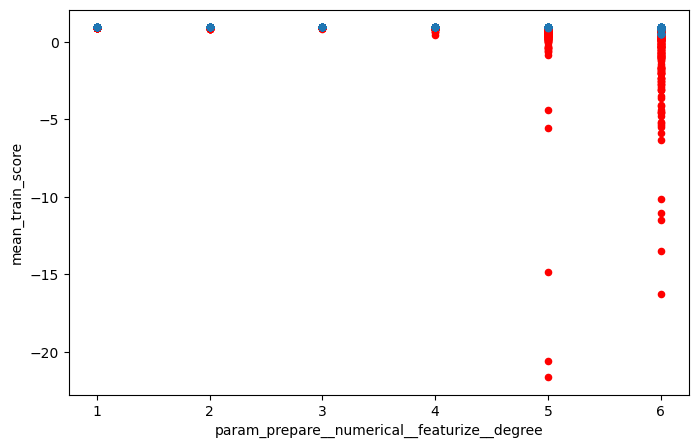

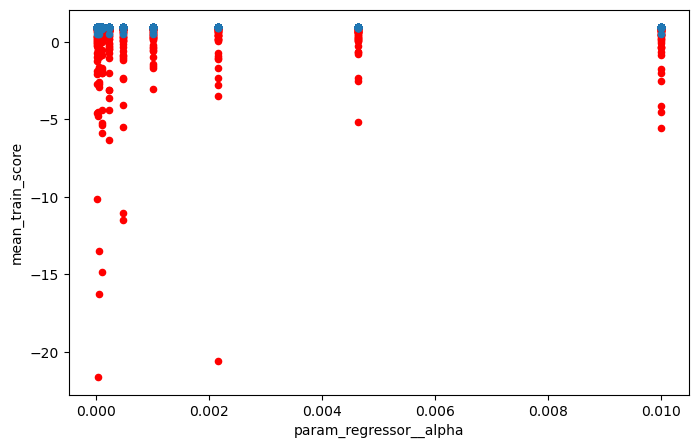

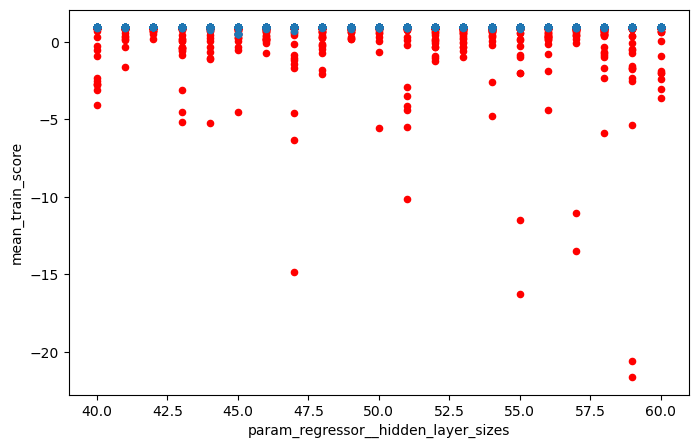

In [19]:
# ANN Regression

from sklearn import model_selection
from sklearn import pipeline
from sklearn import neural_network
from sklearn import compose
from sklearn import preprocessing

target = 'Cell_viab'
features = ['AgY' ,'Ag(5-FU)@Y','5-FU@Y']
basename = '221122-modelo_linear'

train_set, test_set = model_selection.train_test_split(s_data,train_size=0.6,random_state=42)

X_train = train_set[features]
Y_train = train_set[target]
X_test = test_set[features]
Y_test = test_set[target]

num_pross = pipeline.Pipeline(steps=[('scale',preprocessing.StandardScaler()),
                                     ('featurize',preprocessing.PolynomialFeatures())])

pre_transformer = compose.ColumnTransformer([
                  ('numerical',num_pross,compose.make_column_selector(dtype_include=np.number),
                  )
                   ], remainder='passthrough')

reg = neural_network.MLPRegressor(solver='lbfgs', max_iter=10_000, random_state=42)

model_pipe = pipeline.Pipeline(steps=[('prepare',pre_transformer),
                                      ('regressor',reg)])

hyper_params=dict()
#hyper_params["regressor__C"]= np.linspace(0.5,1.5, 10)
hyper_params["prepare__numerical__featurize__degree"]=[1,2,3,4,5,6]
#hyper_params["regressor__alpha"]= np.linspace(0.00001,0.01, 40)
hyper_params["regressor__alpha"]= np.logspace(-5,-2, 10)
hyper_params["regressor__hidden_layer_sizes"]=[(x,) for x in np.arange(40,61)]


s_model = model_selection.GridSearchCV(model_pipe,hyper_params,refit=True, return_train_score=True, n_jobs=4, verbose=1)
#model = model_pipe

start=time.time()
s_model.fit(X_train,Y_train)
end=time.time()

print(f"Score (train) = {s_model.score(X_train,Y_train):6.4f}")
print(f"Score (test)  = {s_model.score(X_test,Y_test):6.4f}")
print(f"Time to train = {end-start:0.1f} s")

fig, axs = plt.subplots(1,2,figsize=(14,6))
axs[0].set_title("Fitness Plot")
make_fitness_plot(s_model,X_train,Y_train,X_test,Y_test,'Cell Viability (%)',ax=axs[0])
axs[1].set_title("Residuals")
make_residual_plot(s_model,X_train,Y_train,X_test,Y_test,'Cell Viability (%)',ax=axs[1])
plt.show()

if True:
    # Best estimator hyper-parameters
    print("Best parameters:")
    for pname,val in s_model.best_params_.items():
      print(f"{pname:20s}: {val}")
    cv_data=pd.DataFrame(s_model.cv_results_)
    cv_data["param_regressor__hidden_layer_sizes"] = [x[0] for x in cv_data["param_regressor__hidden_layer_sizes"]]
    for k in hyper_params:
        _, ax= plt.subplots(figsize=(8,5))
        l1=cv_data.plot.scatter(x=f"param_{k}",y="mean_test_score",ax=ax,color='red')
        l2=cv_data.plot.scatter(x=f"param_{k}",y="mean_train_score",ax=ax)
        plt.show()